# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
!pip3 install tensorflow==2.1.0 pillow matplotlib
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Using cached tensorflow-2.1.0-cp37-cp37m-win_amd64.whl (355.8 MB)
Processing c:\users\bagavathi priya\appdata\local\pip\cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd\gast-0.2.2-cp37-none-any.whl
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.

You should consider upgrading via the 'e:\installed\anaconda\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/am1tyadav/tfutils.git to c:\users\bagava~1\appdata\local\temp\pip-req-build-mdk59v88
  Created wheel for tfutils: filename=tfutils-0.0.1-py3-none-any.whl size=6488 sha256=c1d45a8f981254bc2e57146ba00edc60c79ec7e054af8efd13c3e3ebc7a2c2b2
  Stored in directory: C:\Users\BAGAVA~1\AppData\Local\Temp\pip-ephem-wheel-cache-2w6ye49i\wheels\76\26\c1\59c11d1b3edc8644c22d4251d283ce58f43ca5e99eb08268ad
Successfully built tfutils


You should consider upgrading via the 'e:\installed\anaconda\python.exe -m pip install --upgrade pip' command.


In [2]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)

x = np.concatenate([x_train, x_test], axis=0)

11493376/11490434 [==============================] - 26s 2us/step


In [4]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

<IPython.core.display.Javascript object>

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [5]:
size = 28
noise_dim = 1

discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

# Task 4: Generator

In [6]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(noise_dim,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid')

])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

In [7]:
noise = np.random.randn(1, noise_dim)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary');

<IPython.core.display.Javascript object>

# Task 5: Generative Adversarial Network (GAN)

In [8]:
input_layer = tf.keras.layers.Input(shape=(noise_dim,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

Steps per epoch= 107


<IPython.core.display.Javascript object>


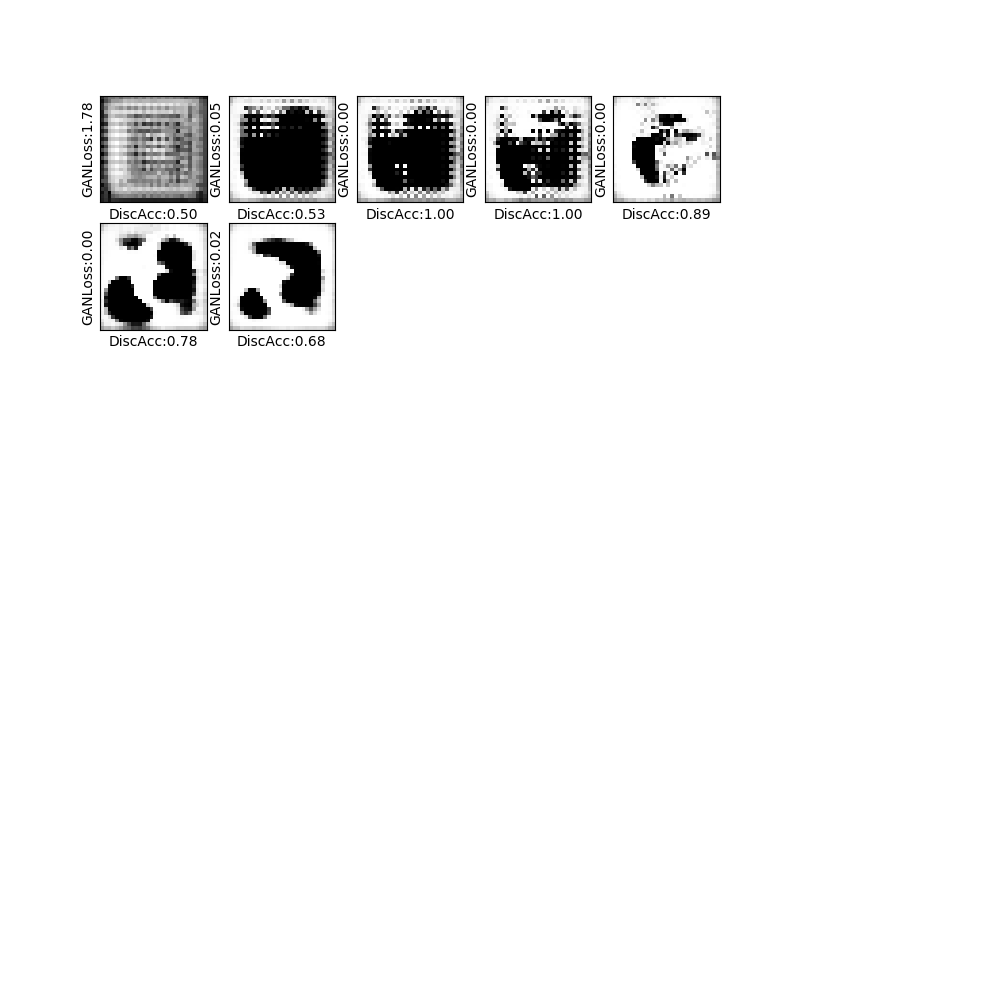

In [ ]:
%%time

epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch=', steps_per_epoch)

dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

        noise = np.random.randn(int(batch_size/2), noise_dim)
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0)
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]

        # train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        # train the generator
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))

        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)

    noise = np.random.randn(1, noise_dim)
    generated_example = generator.predict(noise)[0]
    
    dp.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary',
                   'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))